In [1]:
# Standard
import logging
import importlib
import torch_geometric
import dgl
import copy

# Third party
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
import torchmetrics
from torchmetrics import AUROC
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist

from dgl.dataloading import GraphDataLoader
from dgl.nn.pytorch import GATConv, SumPooling, AvgPooling, MaxPooling, GATv2Conv
from dgl.nn import GraphConv, SAGEConv

import torch.nn.functional as F
from torch_geometric.nn import summary
from pytorch_metric_learning import losses, miners, reducers, distances
from pytorch_metric_learning.distances import LpDistance

# GT-PyG
from dgl.data import DGLDataset


# Turn off majority of RDKit warnings

# Set a random seed for a reproducibility purposes
torch.manual_seed(1928374650)

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Log the used versions of RDkit and torch
print(f'Numpy version: {np.__version__}')
print(f'Torch version: {torch.__version__}')
print(f'TorchMetrics version: {torchmetrics.__version__}')

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Numpy version: 1.26.4
Torch version: 2.6.0+cu124
TorchMetrics version: 1.7.1


In [2]:
import anndata as ad
adata = ad.read_h5ad(r'../adjTMA_cleangmm.h5ad')

/home/akilgall/miniconda3/envs/dgl_cuda_cox_new/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos'

In [138]:
df = adata.obs[['CT_final', 'x', 'y', 'unique_core', 'Relapse', 'Relapse_status', 'Relapse_followup', 'Surv_status', 'Surv_Followup', 
       'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'pd1_median_pos', 
       'Ki67_pos', 'G6PD_pos', 'pNRF2_pos', 'pdl1_median_pos',
       'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos',
       'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'protein_exp_nb', 'Hypoxic',
       'OxPhos', 'Mitochondrial', 'Oxidative_Stress', 'Lipid_Oxidation', 'PPP',
       'Glutamine_import']]

In [19]:
adata.obs['CT_final'].value_counts()

CT_final
Tumour                    225783
Other_Stromal_cells       128939
Macrophages               110021
Fibroblast                102592
CD4_cells                 100664
CD8_cells                  65310
Vessels                    64901
CD44+                      59525
MHC_II                     47561
Macrophages_M2             35610
Proliferating              31196
B_cells                    29657
MHC_I                      26257
MHC_II_CD44+               22290
MHC_I&II                   13392
MHC_I_CD44+                12941
Macrophages_PDL1+          12017
Proliferating_MHC_I        10152
Macrophages_M2_PDL1+        9521
CD44+_PDL1+                 9028
Proliferating_CD44+         7743
MHC_I&II_CD44+              7647
PDL1+                       7114
CD4_TFH                     5863
Proliferating_PDL1          5707
PDL1_MHC_I                  5581
PDL1_MHC_I&II               5468
PD1+_CD8_cells              5254
PDL1_MHC_I&II_CD44+         4105
Proliferating_MHC_I&II      3762
C

In [20]:
df.to_csv('graphData_adjTMA.csv')

In [142]:
functional_cols = ['pdl1_median_pos',
       'pd1_median_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 
       'Ki67_pos', 'G6PD_pos', 'pNRF2_pos',
       'ATPA5_pos', 'GLUT1_pos', 'Hexokinase1_pos', 'ASCT2_pos', 'SDHA_pos',
       'CPT1A_pos', 'CITRATE_SYNTHASE_pos', 'Hypoxic',
       'OxPhos', 'Mitochondrial', 'Oxidative_Stress', 'Lipid_Oxidation', 'PPP',
       'Glutamine_import']

In [143]:
def returnKNNNeighbors(ndf, xcol, ycol, rad):
    edges, distances = [], []
    points = np.array([[a, b] for a, b in zip(ndf[xcol].to_numpy(), ndf[ycol].to_numpy()) ])
    
    tree = KDTree(points, leaf_size=2)
    all_nn_indices = tree.query_radius(points, r=rad)

    cdists = cdist(points, points)

    for i in range(len(all_nn_indices)):
        for j in range(len(all_nn_indices[i])):
            if i != all_nn_indices[i][j]:
                edges.append([i, all_nn_indices[i][j]])
                distances.append(cdists[i, all_nn_indices[i][j]])
    return np.array(edges), np.array(distances)

cell_types_cols = list(sorted(set(df['CT_final'])))

def returnGraph(patientdf, rad, extras=False):
    edges, distances = returnKNNNeighbors(patientdf, xcol='x', ycol='y', rad=rad)
    edges_data = pd.DataFrame(edges, columns=['source', 'destination'])
    edges_data['distances'] = distances#Added for WGAT

    node_features = pd.get_dummies(patientdf["CT_final"]).reindex(columns=cell_types_cols, fill_value=False).astype(int).astype(float)
    node_features = pd.concat([node_features, patientdf[functional_cols]], axis=1)
    node_features = torch.from_numpy(node_features.to_numpy()).float()

    node_labels = torch.from_numpy(
        patientdf["Relapse"].astype("category").cat.codes.to_numpy()).long()

    edges_src = torch.from_numpy(edges_data["source"].to_numpy())
    edges_dst = torch.from_numpy(edges_data["destination"].to_numpy())
    graph = dgl.graph(
        (edges_src, edges_dst), num_nodes=len(node_features)#patientdf.shape[0]
    )
    graph.ndata["feat"] = node_features
    graph = dgl.to_bidirected(graph, copy_ndata=True)

    # 50 is the noramlizing factor here!
    graph.edata['dist'] = torch.from_numpy(edges_data["distances"].to_numpy() / 50.0).float()

    
    return graph, patientdf["Relapse"].iloc[0], [1]#list(patientdf[["BOR", "patient_id", "pfs.T", "pfs.E", "os.T", "os.E", "pfs.6months", "pfs.12months", "OS.24months"]].iloc[0])

In [144]:
len(cell_types_cols)

34

In [145]:
cell_types_cols

['B_cells',
 'CD44+',
 'CD44+_PDL1+',
 'CD4_TFH',
 'CD4_cells',
 'CD8_cells',
 'Cytotoxic_CD8_cells',
 'Fibroblast',
 'MHC_I',
 'MHC_I&II',
 'MHC_I&II_CD44+',
 'MHC_II',
 'MHC_II_CD44+',
 'MHC_I_CD44+',
 'Macrophages',
 'Macrophages_M2',
 'Macrophages_M2_PDL1+',
 'Macrophages_PDL1+',
 'Other_Stromal_cells',
 'PD1+_CD8_cells',
 'PDL1+',
 'PDL1_MHC_I',
 'PDL1_MHC_I&II',
 'PDL1_MHC_I&II_CD44+',
 'PDL1_MHC_II',
 'PDL1_MHC_I_CD44+',
 'Proliferating',
 'Proliferating_CD44+',
 'Proliferating_MHC_I',
 'Proliferating_MHC_I&II',
 'Proliferating_MHC_II',
 'Proliferating_PDL1',
 'Tumour',
 'Vessels']

In [146]:
cell_types_cols + functional_cols

['B_cells',
 'CD44+',
 'CD44+_PDL1+',
 'CD4_TFH',
 'CD4_cells',
 'CD8_cells',
 'Cytotoxic_CD8_cells',
 'Fibroblast',
 'MHC_I',
 'MHC_I&II',
 'MHC_I&II_CD44+',
 'MHC_II',
 'MHC_II_CD44+',
 'MHC_I_CD44+',
 'Macrophages',
 'Macrophages_M2',
 'Macrophages_M2_PDL1+',
 'Macrophages_PDL1+',
 'Other_Stromal_cells',
 'PD1+_CD8_cells',
 'PDL1+',
 'PDL1_MHC_I',
 'PDL1_MHC_I&II',
 'PDL1_MHC_I&II_CD44+',
 'PDL1_MHC_II',
 'PDL1_MHC_I_CD44+',
 'Proliferating',
 'Proliferating_CD44+',
 'Proliferating_MHC_I',
 'Proliferating_MHC_I&II',
 'Proliferating_MHC_II',
 'Proliferating_PDL1',
 'Tumour',
 'Vessels',
 'pdl1_median_pos',
 'pd1_median_pos',
 'HLA-DR_pos',
 'HLA-A_pos',
 'ICOS(CD278)_pos',
 'Ki67_pos',
 'G6PD_pos',
 'pNRF2_pos',
 'ATPA5_pos',
 'GLUT1_pos',
 'Hexokinase1_pos',
 'ASCT2_pos',
 'SDHA_pos',
 'CPT1A_pos',
 'CITRATE_SYNTHASE_pos',
 'Hypoxic',
 'OxPhos',
 'Mitochondrial',
 'Oxidative_Stress',
 'Lipid_Oxidation',
 'PPP',
 'Glutamine_import']

In [147]:
def returnGraphs(patients_to_select):
    batchI, totalGraphs = 0, 0
    graphs, labels, patients_ids, metas = [], [], [], []
    for graphI, (patient_id, patdf) in enumerate(df.groupby(by='unique_core')):
        if np.isnan(patdf['Relapse'].iloc[0]) or type(patdf['Relapse'].iloc[0]) == str or \
            patdf['unique_core'].iloc[0] not in patients_to_select:
            continue

        g, l, meta = returnGraph(patdf, 100.0)
        g = dgl.add_self_loop(g, fill_data=0.0)
        g.ndata['labels'] = l*torch.ones(g.num_nodes())
        g.ndata['graph'] = totalGraphs*torch.ones(g.num_nodes())
        g.ndata['nid'] = torch.tensor(list(range(g.num_nodes())))

        graphs.append(g)
        labels.append(l)
        patients_ids.append(patient_id)
        metas.append(meta)
        totalGraphs += 1

    return graphs, labels, metas

In [148]:
def returnBG(patients):
    gS, lS, metaS = returnGraphs(patients)
    bg = dgl.batch(gS)
    return bg, metaS

In [149]:
def edge_jitter(g, scale=0.1):
    aug_g = copy.deepcopy(g)
    feats = g.edata['dist']
    feats = feats + feats*torch.normal(torch.zeros(feats.shape), scale*torch.ones(feats.shape))
    aug_g.edata['dist'] = feats
    return aug_g

def edge_dropout(g, drop_prob):
    """Randomly drop edges in the graph with a given probability."""
    # Get all edges
    src, dst = g.edges()
    num_edges = g.number_of_edges()

    # Generate a mask for dropping edges
    mask = torch.rand(num_edges) > drop_prob
    src = src[mask]
    dst = dst[mask]

    # Create a new graph with the remaining edges
    new_g = dgl.graph((src, dst), num_nodes=g.number_of_nodes())
    new_g.ndata.update(g.ndata)  # Copy node features
    # If edge features exist, copy them accordingly
    if 'dist' in g.edata:
        new_g.edata['dist'] = g.edata['dist'][mask]
    return new_g

def node_feature_masking(g, mask_prob):
    """Randomly mask node features with a given probability."""
    g = copy.deepcopy(g)
    feats = g.ndata['feat']
    #feats = feats + 1*torch.randn(feats.shape)#.to(device)
    mask = torch.rand_like(feats) > mask_prob
    g.ndata['feat'] = feats * mask

    mask2 = torch.rand(feats.shape[1]) > mask_prob
    g.ndata['feat'] = mask2.repeat(mask.shape[0], 1)*feats
    
    return g


def graph_augmentation_pipeline(g, edge_drop_prob=0.05, feature_mask_prob=0.05, edge_jitter_scale=0.05, node_drop_prob=0.05):
    """Apply edge dropout and node feature masking to the graph."""
    # Apply edge dropout
    aug_g = edge_dropout(g, edge_drop_prob)
    # Apply node feature masking
    aug_g = node_feature_masking(aug_g, feature_mask_prob)
    aug_g = edge_jitter(aug_g, edge_jitter_scale)

    aug_g = dgl.remove_nodes(aug_g, torch.tensor(np.random.choice(list(range(aug_g.num_nodes())), int(node_drop_prob*aug_g.num_nodes()))))

    return aug_g

In [150]:
from torch_geometric.utils import remove_isolated_nodes

class YTMAGraphs(DGLDataset):
    def __init__(self, patient_indices):
        self.patient_indices = patient_indices
        self.bg = None
        self.metas = None
        self.sampling_layers=1
        super().__init__(name="ytma")

    def process(self):
        self.bg, self.metas = returnBG(self.patient_indices)

    def __getitem__(self, i):
        #numLayers = max(np.random.poisson(self.sampling_layers), 1)
        subgraph, _ = dgl.khop_in_subgraph(self.bg, i, 2)
        subgraph = graph_augmentation_pipeline(subgraph)

        #subgraph = remove_isolated_nodes(subgraph)
        isolated_nodes = ((subgraph.in_degrees() == 0) & (subgraph.out_degrees() == 0)).nonzero().squeeze(1)
        subgraph = dgl.remove_nodes(subgraph, isolated_nodes)

        return subgraph, self.bg.ndata['labels'][i], self.metas[int(self.bg.ndata['graph'][i])]+[i]

    def __len__(self):
        return self.bg.num_nodes()

In [151]:
keys = ['Relapse'] + functional_cols

In [155]:
def mapping(x):
    if type(x) == bool:
        return int(x)

    if not type(x) is str:
        return float(x)
    
    if 'neg' in x:
        return 0
    elif 'pos' in x or '+' in x:
        return 1
    elif 'Yes' in x:
        return 1
    elif 'No' in x:
        return 0
    else:
        print("ERROR\t", key)
        return x
    
for key in keys:
    df[key] = df[key].apply(mapping)

/tmp/ipykernel_21431/3780581682.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df[key].apply(mapping)


In [158]:
trainIds = ['TMA_A_A2', 'TMA_A_A5', 'TMA_A_A6', 'TMA_A_C1', 'TMA_A_C6', 'TMA_A_C7', 'TMA_A_E4', 'TMA_A_E6', 'TMA_A_E7', 'TMA_A_G2', 'TMA_A_G5', 'TMA_A_G6', 'TMA_A_G7', 'TMA_A_I7', 'TMA_B_A1', 'TMA_B_A2', 'TMA_B_A6', 'TMA_B_C3', 
            'TMA_B_C7', 'TMA_B_E5', 'TMA_B_G5', 'TMA_B_G6', 'TMA_B_I2', 'TMA_B_I3', 'TMA_A_B3', 'TMA_A_B4', 'TMA_A_B7', 'TMA_A_D5', 'TMA_A_F1', 'TMA_A_F3', 'TMA_A_F5', 'TMA_A_H1', 'TMA_A_J2', 'TMA_A_J4', 'TMA_A_J5', 'TMA_A_J6', 
            'TMA_B_B8', 'TMA_B_D1', 'TMA_B_D2', 'TMA_B_D6', 'TMA_B_D8', 'TMA_B_F2', 'TMA_B_F3', 'TMA_B_F4', 'TMA_B_F8', 'TMA_B_H4', 'TMA_B_H7', 'TMA_B_J7', 'TMA_A_C2', 'TMA_A_C3', 'TMA_B_D4', 'TMA_B_C5', 'TMA_B_G1', 'TMA_B_G3', 
            'TMA_B_I8',]

df.loc[:,functional_cols] = df.loc[:,functional_cols].fillna(0.0)
ds = YTMAGraphs(trainIds)

/tmp/ipykernel_21431/2452592231.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for graphI, (patient_id, patdf) in enumerate(df.groupby(by='unique_core')):


In [136]:
df.loc[:,functional_cols].fillna(0.0)

,pdl1_median_pos,pd1_median_pos,pd1_median_pos,HLA-DR_pos,HLA-A_pos,ICOS(CD278)_pos,Ki67_pos,G6PD_pos,pNRF2_pos,ATPA5_pos,...,SDHA_pos,CPT1A_pos,CITRATE_SYNTHASE_pos,Hypoxic,OxPhos,Mitochondrial,Oxidative_Stress,Lipid_Oxidation,PPP,Glutamine_import
0,0.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.0,0.0,0.0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187506,0.0,0.0,0.0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,1,0
1187507,0.0,0.0,0.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1187508,0.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1187509,0.0,0.0,0.0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0


In [160]:
functional_cols

['pdl1_median_pos',
 'pd1_median_pos',
 'HLA-DR_pos',
 'HLA-A_pos',
 'ICOS(CD278)_pos',
 'Ki67_pos',
 'G6PD_pos',
 'pNRF2_pos',
 'ATPA5_pos',
 'GLUT1_pos',
 'Hexokinase1_pos',
 'ASCT2_pos',
 'SDHA_pos',
 'CPT1A_pos',
 'CITRATE_SYNTHASE_pos',
 'Hypoxic',
 'OxPhos',
 'Mitochondrial',
 'Oxidative_Stress',
 'Lipid_Oxidation',
 'PPP',
 'Glutamine_import']

In [161]:
ds.bg

Graph(num_nodes=594651, num_edges=111854273,
      ndata_schemes={'feat': Scheme(shape=(56,), dtype=torch.float32), 'labels': Scheme(shape=(), dtype=torch.float32), 'graph': Scheme(shape=(), dtype=torch.float32), 'nid': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'dist': Scheme(shape=(), dtype=torch.float32)})

In [162]:
def formLoader(batch_size=32, shuffle=True):
    train_loader = GraphDataLoader(
        ds, batch_size=batch_size, drop_last=False, shuffle=shuffle)#, num_workers=12)
    return train_loader

def formValLoader(batch_size=32, shuffle=True):
    train_loader = GraphDataLoader(
        ds_valid, batch_size=batch_size, drop_last=False, shuffle=shuffle)#, num_workers=12)
    return train_loader

In [163]:
train_loader = formLoader(batch_size=32)
#valid_loader = formValLoader(batch_size=32)

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def testModel():
    #temp_loader = formValLoader()
    it = iter(train_loader)
    batch = next(it)
    edges = batch[0].edges()
    edges_ = []
    for i in range(len(edges[0])):
        edges_.append([edges[0][i], edges[1][i]])
    edges = torch.tensor(np.array(edges_), dtype=torch.long).T

    num_nodes = batch[0].batch_num_nodes()
    batches = torch.repeat_interleave(torch.arange(len(num_nodes)), num_nodes)
    
    plt.hist(batches.numpy())
    plt.xlabel('Number in Each Batch')
    plt.show()
    plt.hist(batch[0].edata['dist'])
    plt.show()

    print(summary(model.to(device), batch[0].ndata['feat'].to(device), edges.to(device), batch[0].edata["dist"].unsqueeze(-1).float().to(device), batches.to(device)))
    #print(summary(model.to(device), batch[0].to(device), batch[0].ndata["feat"].float().to(device), batch[0].edata["dist"].float().to(device)))

cuda


In [165]:
from torch_geometric.nn import TransformerConv, global_mean_pool, global_max_pool

class GraphTransformerModel(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, num_classes, num_layers=4, heads=4, dropout=0.1):
        super(GraphTransformerModel, self).__init__()
        self.input_dim = input_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.dropout = dropout
        edge_hidden_dim = 1

        # Input projection for node features
        self.node_embedding = nn.Linear(input_dim, hidden_dim)
        self.edge_embedding = nn.Linear(edge_dim, edge_hidden_dim)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerConv(input_dim + hidden_dim, hidden_dim, heads=heads, dropout=dropout, edge_dim=edge_hidden_dim)
        ])
        for _ in range(num_layers):
            self.transformer_layers.append(TransformerConv(input_dim + (hidden_dim)*heads, hidden_dim, heads=heads, dropout=dropout, edge_dim=edge_hidden_dim))

        # Global pooling
        self.global_pooling = global_mean_pool

        # Output layer
        self.output_layer = nn.Linear((hidden_dim)*heads, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        x: Node features [num_nodes, input_dim]
        edge_index: Graph connectivity [2, num_edges]
        edge_attr: Edge features [num_edges, edge_dim]
        batch: Batch vector [num_nodes] mapping nodes to graphs
        """
        imp_emb = x

        # Embed node and edge features
        x = self.node_embedding(x)  # [num_nodes, hidden_dim]
        x = F.sigmoid(x)
        edge_attr = self.edge_embedding(edge_attr)  # [num_edges, hidden_dim]
        edge_attr = F.sigmoid(edge_attr)

        # Apply transformer layers
        for i, transformer in enumerate(self.transformer_layers):
            x = transformer(torch.concat([x, imp_emb], axis=-1), edge_index, edge_attr)
            x = F.sigmoid(x)  # Apply non-linearity
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling for graph classification
        x = self.global_pooling(x, batch)  # [num_graphs, hidden_dim]
        x = self.output_layer(x)  # [num_graphs, num_classes]

        return x

model = GraphTransformerModel(input_dim=ds.bg.ndata['feat'].shape[1], edge_dim=1, hidden_dim=ds.bg.ndata['feat'].shape[1]//2, num_classes=1, num_layers=2, heads=1, dropout=0.2)

In [166]:
print(model)

GraphTransformerModel(
  (node_embedding): Linear(in_features=56, out_features=28, bias=True)
  (edge_embedding): Linear(in_features=1, out_features=1, bias=True)
  (transformer_layers): ModuleList(
    (0-2): 3 x TransformerConv(84, 28, heads=1)
  )
  (output_layer): Linear(in_features=28, out_features=1, bias=True)
)


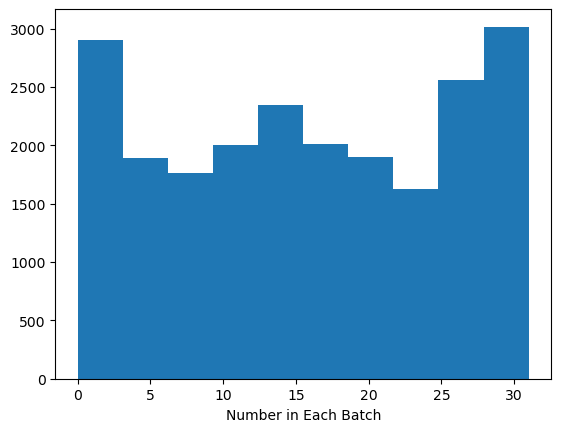

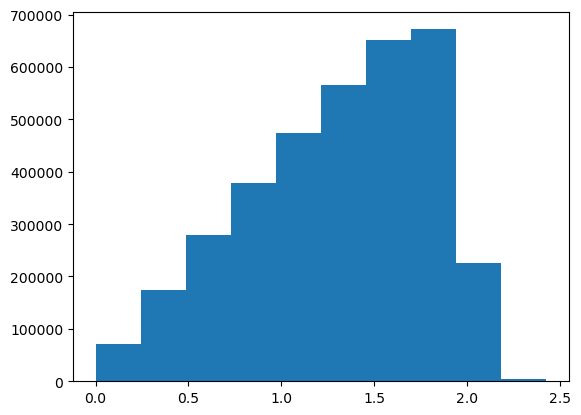

+----------------------------------+--------------------------------------------------+----------------+----------+
| Layer                            | Input Shape                                      | Output Shape   | #Param   |
|----------------------------------+--------------------------------------------------+----------------+----------|
| GraphTransformerModel            | [22009, 56], [2, 3496689], [3496689, 1], [22009] | [32, 1]        | 30,271   |
| ├─(node_embedding)Linear         | [22009, 56]                                      | [22009, 28]    | 1,596    |
| ├─(edge_embedding)Linear         | [3496689, 1]                                     | [3496689, 1]   | 2        |
| ├─(transformer_layers)ModuleList | --                                               | --             | 28,644   |
| │    └─(0)TransformerConv        | [22009, 84], [2, 3496689], [3496689, 1]          | [22009, 28]    | 9,548    |
| │    └─(1)TransformerConv        | [22009, 84], [2, 3496689], [3496689

In [167]:
testModel()

In [168]:
def validate():
    valid_loader = formValLoader(batch_size=64)
    model.eval()
    criterion = nn.BCELoss()
    
    lenloader = len(valid_loader)
    meanloss = 0.0
    for i, (batched_graph, labels, _) in enumerate(valid_loader):
        edges = torch.vstack(batched_graph.edges())

        num_nodes = batched_graph.batch_num_nodes()
        graph_ids = torch.repeat_interleave(torch.arange(len(num_nodes)), num_nodes)

        batched_graph = batched_graph.to(device)
        labels = labels.to(device)

        pred = model(batched_graph.ndata['feat'].to(device), edges.to(device), batched_graph.edata["dist"].unsqueeze(-1).float().to(device), graph_ids.to(device)).sigmoid()
        loss = criterion(pred.squeeze(), labels)
            
        meanloss += loss.detach().item()

    return meanloss/(lenloader)

In [169]:
trainlosses, batchlosses = [], []

def train(loader):
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-5)

    model.train()

    distance = distances.LpDistance(normalize_embeddings=False)
    criterion = losses.ContrastiveLoss(distance=distance)
    
    lenloader = len(loader)
    for epoch in range(200):
        meanloss = 0.0
        for i, (batched_graph, labels, _) in enumerate(loader):
            edges = torch.vstack(batched_graph.edges())

            num_nodes = batched_graph.batch_num_nodes()
            graph_ids = torch.repeat_interleave(torch.arange(len(num_nodes)), num_nodes)

            batched_graph = batched_graph.to(device)
            labels = labels.to(device)

            pred = model(batched_graph.ndata['feat'].to(device), edges.to(device), batched_graph.edata["dist"].unsqueeze(-1).float().to(device), graph_ids.to(device)).sigmoid()

            loss = criterion(pred, labels)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchlosses.append(loss.detach().item())
            meanloss += batchlosses[-1]
            print(i, '\t', f'{meanloss/(i+1):.4f}', end="\r")

        trainlosses.append(meanloss/lenloader)
        torch.save(model, "meta_learnRelapse_GraphTransformerNet_PoissonAug_Mar2nd2025_trainIds.pt")
        torch.save(model.state_dict(), "meta_learnRelapse_GraphTransformerNet_PoissonAug_Mar2nd2025_trainIds_dict.pt")

        print("EPOCH: ", epoch, "\t", lenloader, " / ", lenloader, f"  Train loss: {meanloss/(len(loader)):.4f}")#, end='\r')
        print()

    plt.plot(trainlosses)
    plt.savefig('losses_meta.svg')
    plt.show()

In [ ]:
train(train_loader)

In [ ]:
if True:
    model.to(device)
    loaderTest = formLoader(batch_size=64, shuffle=False)
    print("done creating loader")

    model.eval()
    preds, alllabels, ids = [], [], []
    for i, (batched_graph, labels, metas) in enumerate(loaderTest):
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)

        edges = torch.vstack(batched_graph.edges())

        num_nodes = batched_graph.batch_num_nodes()
        graph_ids = torch.repeat_interleave(torch.arange(len(num_nodes)).to(device), num_nodes)

        pred = model(batched_graph.ndata['feat'].to(device), edges.to(device), batched_graph.edata["dist"].unsqueeze(-1).float().to(device), graph_ids.to(device))


        preds.extend(pred.detach().cpu().numpy())
        alllabels.extend(labels.detach().cpu().numpy())
        ids.extend(list(metas[-1].detach().cpu().numpy()))

        if i % 10 == 0:
            print(i, '\t', end="\r")

    preds, alllabels, ids = np.array(preds), np.array(alllabels), np.array(ids)

    h, bins = np.histogram(preds, bins=np.arange(-8, 7, 0.75))
    plt.hist(preds[alllabels == 0], bins=bins, fill=False, edgecolor='k', density=True, label='Non-Relapse')
    plt.hist(preds[alllabels == 1], bins=bins, fill=False, edgecolor='r', density=True, label='Relapse')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
def plotPredictions(preds_, alllabels_):
    preds_, alllabels_ = np.array(preds_).squeeze(), np.array(alllabels_)
    
    h, bins = np.histogram(preds_, bins=np.arange(-8, 7, 0.5))
    plt.hist(preds_[alllabels_ == 1], bins=bins, fill=False, edgecolor='r', density=True, label='Responder')
    plt.hist(preds_[alllabels_ == 0], bins=bins, fill=False, edgecolor='k', density=True, label='Non-Responder')
    plt.yscale('log')
    plt.legend()
    plt.show()

plotPredictions(preds, alllabels)

In [ ]:
from sklearn.neighbors import KernelDensity

#                     Non-Responders  Responders
def kde_overlap_score(data_class1, data_class2, bandwidth=0.3):
    # Fit KDE for each class
    kde_class1 = KernelDensity(bandwidth=bandwidth).fit(data_class1)
    kde_class2 = KernelDensity(bandwidth=bandwidth).fit(data_class2)

    X = np.linspace(-8, 6, 100).reshape(1, -1).T
    log_dens = kde_class1.score_samples(X)
    plt.plot(X, np.exp(log_dens))
    log_dens = kde_class2.score_samples(X)
    plt.plot(X, np.exp(log_dens))
    
    plt.yscale('log')
    #plt.ylim([1e-4, 2])
    plt.show()
    
    
    # How Responder-like the non-responders are
    scores_class1 = np.exp(kde_class2.score_samples(data_class1))

    # How non-responder-like the responders are
    scores_class2 = np.exp(kde_class1.score_samples(data_class2))

    return scores_class1, scores_class2
    
def returnWeightingsFromOverlaps(preds_, alllabels_):
    preds_, alllabels_ = np.array(preds_), np.array(alllabels_)

    # How responder-like the non-responders are, how non-responder-like the responders are
    scores_1, scores_2 = kde_overlap_score(preds_[alllabels_ == 0], preds_[alllabels_ == 1])
    print(scores_1, scores_2)

    # How Responder-like the responders are
    scores_2 = 1.0 - scores_2
    
    h, bins = np.histogram(np.concatenate([scores_1, scores_2]), bins=20)
    plt.hist(scores_1, bins=bins, fill=False, edgecolor='k', density=True, label='How Responder-like the Non-Responders Are')
    plt.hist(scores_2, bins=bins, fill=False, edgecolor='r', density=True, label='How Responder-like the Responders Are')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    return np.concatenate([scores_1, scores_2])

responderlike_scores = returnWeightingsFromOverlaps(preds, alllabels)

In [ ]:
def selectAnomalousClassPoints(preds_, alllabels_, ids_):
    preds_, alllabels_, ids_ = np.array(preds_), np.array(alllabels_), np.array(ids_)

    # How responder-like the non-responders are, how non-responder-like the responders are
    scores_1, scores_2 = kde_overlap_score(preds_[alllabels_ == 0], preds_[alllabels_ == 1])

    cutoff_1 = np.percentile(scores_1, 90.0)
    cutoff_2 = np.percentile(scores_2, 90.0)

    anomalousity = np.concatenate([scores_1 > cutoff_1, scores_2 > cutoff_2]).astype(int)

    return anomalousity, np.concatenate([scores_1[scores_1 > cutoff_1], scores_2[scores_2 > cutoff_2]])

anomalousity, anomalousityScores = selectAnomalousClassPoints(preds, alllabels, ids)

In [ ]:
#cell_types_cols, Immune_func_cols, Immune_meta_cols
def plotFeaturesOfAnomalousPoints(alllabels_, ids_, anomalousity_):
    #if True:
    #anomalousity_, alllabels_, ids_ = anomalousity, alllabels, ids
    anomalousity_, alllabels_, ids_ = np.array(anomalousity_), np.array(alllabels_), np.array(ids_)

    hist_class0, hist_class1, labels = [], [], []
    for i in np.where((anomalousity == 1) & (alllabels_ == 0))[0]:
        hist_class0.append(torch.histogram(ds[i][0].ndata['feat'].argmax(-1).float(), bins=torch.arange(0.0, len(Immune_func_cols)+1, 1.0)))
        labels.append(0)
    for i in np.where((anomalousity == 1) & (alllabels_ == 1))[0]:
        hist_class1.append(torch.histogram(ds[i][0].ndata['feat'].argmax(-1).float(), bins=torch.arange(0.0, len(Immune_func_cols)+1, 1.0)))         
        labels.append(1)

    return np.array([a.hist.numpy() for a in hist_class0]), np.array([a.hist.numpy() for a in hist_class1]), labels

hist_class0, hist_class1, hist_labels = plotFeaturesOfAnomalousPoints(alllabels, ids, anomalousity)

In [ ]:
print("Starting")
fig, ax = plt.subplots(figsize=(10, 8))
plt.step(np.arange(0.0, len(Immune_func_cols), 1.0)+0.5, hist_class0.mean(0), c='k', label='Non-Responders')
plt.step(np.arange(0.0, len(Immune_func_cols), 1.0)+0.5, hist_class1.mean(0), c='r', label='Responders')
plt.yscale('log')
ax.set_xticks(np.arange(0.0, len(Immune_func_cols), 1.0))
ax.set_xticklabels(Immune_func_cols)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
dfOut = pd.DataFrame(np.vstack([hist_class0, hist_class1]), columns=Immune_func_cols)

In [ ]:
dfOut['score'] = anomalousityScores
dfOut['label'] = hist_labels

In [ ]:
labelsToNorm = Immune_func_cols
dfOut[Immune_func_cols] = dfOut[Immune_func_cols]/dfOut[Immune_func_cols].sum(axis=0)
dfOut['label'] += 1
dfOut[dfOut == 0.0] = np.nan
dfOut['label'] -= 1

In [ ]:
import seaborn as sns

In [ ]:
melted_df = dfOut.drop('score', axis=1).melt(id_vars=['label'], var_name="Variable", value_name="Value")


In [ ]:
melted_df

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_df, x="Variable", y="Value", hue='label', whis=(0, 100))
plt.title('Side-by-Side Violin Plot of All Columns Split by Category')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim([5e-6, 8e-3])
plt.show()